<a href="https://colab.research.google.com/github/xarvel/DataScience/blob/master/BIGGAN_birds_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigGan implementainon on Tensorflow 2 with TPU distributed training.

In [1]:
#@title Requirements

!sudo apt-get -qq install gifsicle
!pip install tensorflow-gan tensorflow-addons imageio pygifsicle -q
!rm -rf sample_data checkpoints samples BigGANUtils
!mkdir checkpoints samples
!git clone -q https://github.com/xarvel/BigGANUtils.git

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package gifsicle.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../gifsicle_1.91-2_amd64.deb ...
Unpacking gifsicle (1.91-2) ...
Setting up gifsicle (1.91-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 367 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 80.1 MB/s 


In [2]:
import tensorflow.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Flatten, Embedding, ReLU
from tensorflow.keras.layers import BatchNormalization, Reshape, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import tensorflow_datasets as tfds
from tqdm import tqdm 
import tensorflow_addons as tfa
import functools
import json

from BigGANUtils.SelfAttention import SelfAttention
from BigGANUtils.GBlock import GBlock
from BigGANUtils.DBlock import DBlock
from BigGANUtils.SpectralNormalization import SpectralNormalization
from BigGANUtils.ConditionalBatchNormalization import ConditionalBatchNormalization
from BigGANUtils.SNDense import SNDense 
from BigGANUtils.SNConv2D import SNConv2D
from BigGANUtils.SNEmbedding import SNEmbedding
from BigGANUtils.sample_images import sample_images
from BigGANUtils.sample_single_image import sample_single_image
from BigGANUtils.combine_samples import combine_samples
from BigGANUtils.model_to_img import model_to_img
from BigGANUtils.make_distributed_train_step import make_distributed_train_step
from BigGANUtils.checkpoint_with_history import checkpoint_with_history
from BigGANUtils.sample_analytics import sample_analytics
from BigGANUtils.losses import discriminator_loss, generator_loss
from BigGANUtils.training_loop import training_loop
from BigGANUtils.get_birds_dataset import get_birds_dataset

print(tf.__version__)

2.9.2


In [3]:
#@title TPU CONFIG

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [4]:
#@title CONFIG

IMAGE_SIZE = 224
IMAGE_CHANNELS = 3
DATASET_SIZE = 13262
BUFFER_SIZE = DATASET_SIZE
PER_REPILICA_BATCH_SIZE = 8
GLOBAL_BATCH_SIZE = PER_REPILICA_BATCH_SIZE * strategy.num_replicas_in_sync
EPOCHS = 30
STEPS_PER_EPOCH = DATASET_SIZE // PER_REPILICA_BATCH_SIZE
LATENT_DIM = 126
CHECKPOINT_DIR = 'checkpoints'
SAMPLES_DIR = 'samples'
CHECKPOINT_INTERVAL = 5
SEED = 1
NUM_CLASSES = 100
SAMPLE_INTERVAL = 1

GAN_FILTERS = 40
GENERATOR_LR = 0.0001
DISCRIMINATOR_LR = 0.0004
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.99
ADAM_EPSILON = 1e-07
SN_EPSILON = 1e-12
BN_EPSILON = 0.001

EMA_DECAY = 0.99
EMA_START = 20000

In [5]:
tf.random.set_seed(SEED)
weight_initializer = tf.keras.initializers.Orthogonal(seed=SEED)
fixed_noise = tf.random.truncated_normal((LATENT_DIM,), stddev=1)

In [6]:
#@title Dataset

train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_birds_dataset(
    batch_size=PER_REPILICA_BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
    is_training=True
))

In [7]:
#@title Generator

class Generator(Model):
  def __init__(self, channels, num_classes, embedding_size, **kwargs):
    super(Generator, self).__init__(**kwargs)

    self.batch_normalization = tf.keras.layers.experimental.SyncBatchNormalization
    self.channels = channels
    self.dense = SNDense
    self.conv2d = SNConv2D
    self.sn_epsilon = SN_EPSILON
    self.bn_epsilon = BN_EPSILON

    self.linear = self.dense(
        units = 7 * 7 * 16 * channels, 
        use_bias=False, 
        kernel_initializer=weight_initializer, 
        sn_epsilon=self.sn_epsilon, 
        name='linear'
    )
    self.reshape = Reshape([7, 7, 16 * channels], name='reshape')

    res_block = functools.partial(
        GBlock,
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        dense=self.dense, 
        batch_normalization=self.batch_normalization,
        bn_epsilon=self.bn_epsilon, 
        sn_epsilon=self.sn_epsilon, 
    )

    attention = functools.partial(
        SelfAttention,
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon,
    )

    self.res_block_1 = res_block(out_channels = 16 * channels, name='res_block_1')
    self.res_block_2 = res_block(out_channels = 8 * channels, name='res_block_2')  
    self.res_block_3 = res_block(out_channels = 4 * channels, name='res_block_3')  
    self.res_block_4 = res_block(out_channels = 2 * channels, name='res_block_4') 
    self.res_block_5 = res_block(out_channels = channels,name='res_block_5')
    self.attention_1 = attention(name='attention')
    self.embedding = Embedding(
        input_dim = num_classes, 
        output_dim = embedding_size, 
        embeddings_initializer=weight_initializer, 
        name='embedding'
    )
    self.bn = self.batch_normalization(name='batch_normalization', epsilon=self.bn_epsilon)
    self.relu = ReLU(name='activation_relu')
    self.conv = self.conv2d(
        filters=IMAGE_CHANNELS, 
        kernel_size=3, 
        padding='same', 
        kernel_initializer=weight_initializer, 
        name='conv', 
        sn_epsilon=self.sn_epsilon
    )
    self.concat = Concatenate(name='concatenate');
    self.tanh = Activation('tanh', name = 'tanh');

  def call(self, inputs, training=None):    
    z, label = inputs    
    z_split = tf.split(z, num_or_size_splits=6, axis=-1)
    embed = self.embedding(label)
    conds = [self.concat([z_i, embed]) for z_i in z_split[1:]]
    x = self.linear(z_split[0], training=training)
    x = self.reshape(x)
    x = self.res_block_1([x, conds[0]], training=training)
    x = self.res_block_2([x, conds[1]], training=training)
    x = self.res_block_3([x, conds[2]], training=training)
    x = self.res_block_4([x, conds[3]], training=training)
    x = self.attention_1(x, training=training)
    x = self.res_block_5([x, conds[4]], training=training)
    x = self.bn(x, training=training)
    x = self.relu(x)
    x = self.conv(x, training=training)
    return self.tanh(x)

In [8]:
#@title Discriminator

class Discriminator(Model):
  def __init__(self, 
      channels, 
      num_classes, 
      **kwargs
    ):
    super(Discriminator, self).__init__(**kwargs)

    self.dense = functools.partial(
        SNDense,
        kernel_initializer=weight_initializer, 
        sn_epsilon=self.sn_epsilon, 
    )
    self.conv2d = SNConv2D
    self.sn_epsilon = SN_EPSILON
    self.bn_epsilon = BN_EPSILON

    embedding = functools.partial(
        SNEmbedding,
        embeddings_initializer=weight_initializer, 
        sn_epsilon=self.sn_epsilon,
    )

    res_block = functools.partial(
        DBlock,
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon, 
    )

    attention = functools.partial(
        SelfAttention,
        kernel_initializer=weight_initializer, 
        conv2d=self.conv2d, 
        sn_epsilon=self.sn_epsilon,
    )

    self.res_block_1 = res_block(out_channels = 1 * channels, downsample=True, preactivation=False, name='res_block_1')
    self.res_block_2 = res_block(out_channels = 2 * channels, downsample=True, preactivation=True, name='res_block_2')
    self.res_block_3 = res_block(out_channels = 4 * channels, downsample=True, preactivation=True, name='res_block_3')
    self.res_block_4 = res_block(out_channels = 8 * channels, downsample=True, preactivation=True, name='res_block_4')
    self.res_block_5 = res_block(out_channels = 8 * channels, downsample=True, preactivation=True, name='res_block_5')
    self.res_block_6 = res_block(out_channels = 16 * channels, downsample=False, preactivation=True, name='res_block_6')
    self.attention_1 = attention(name='attention')
    self.relu = ReLU(name='relu')
    self.embedding_1 = self.embedding(input_dim = num_classes, output_dim = 16 * channels, name='embedding')
    self.linear = self.dense(units = 1, name='linear')
  
  @tf.function
  def call(self, inputs, training=False):
    x, label = inputs
    x = self.res_block_1(x, training=training)
    x = self.res_block_2(x, training=training)
    x = self.res_block_3(x, training=training)
    x = self.res_block_4(x, training=training)
    x = self.attention_1(x, training=training)
    x = self.res_block_5(x, training=training)
    x = self.res_block_6(x, training=training)
    x = self.relu(x)
    x = tf.reduce_sum(x, axis=[1, 2])
    out = self.linear(x, training=training)
    embed = self.embedding_1(label)
    out += tf.reduce_sum(x * embed, axis=-1, keepdims=True)
    return out

In [9]:
with strategy.scope():
  generator = Generator(GAN_FILTERS, num_classes=NUM_CLASSES, embedding_size=LATENT_DIM, name='generator')
  generator.build(input_shape=[(None, LATENT_DIM,), (None,)])
  discriminator = Discriminator(GAN_FILTERS, num_classes=NUM_CLASSES, name='discriminator')
  discriminator.build(input_shape=[(None, IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS), (None,)])

In [10]:
with strategy.scope():
  generator_optimizer = tfa.optimizers.MovingAverage(Adam(
      learning_rate=GENERATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2,
      epsilon=ADAM_EPSILON
  ), average_decay=EMA_DECAY, start_step=EMA_START)
  
  discriminator_optimizer = Adam(
      learning_rate=DISCRIMINATOR_LR, 
      beta_1=ADAM_BETA_1, 
      beta_2=ADAM_BETA_2, 
      epsilon=ADAM_EPSILON
  )

def with_average_generator(func):
  def inner(*args, **kwargs):
    with strategy.scope():
      generator_optimizer.swap_weights()        
      func(*args, **kwargs)
      generator_optimizer.swap_weights()   
 
  return inner  

In [11]:
sample_analytics = functools.partial(
    sample_analytics,
    dir=SAMPLES_DIR,
    generator_lr=GENERATOR_LR,
    discriminator_lr=DISCRIMINATOR_LR,
    filters=GAN_FILTERS,
    batch_size=PER_REPILICA_BATCH_SIZE
)

In [12]:
sample_images = functools.partial(
    sample_images,
    num_classes = NUM_CLASSES,
    image_size = IMAGE_SIZE,
    noise = fixed_noise,
    generator = generator,
    save_dir = SAMPLES_DIR,
    zoom=0.7
)
sample_images = with_average_generator(sample_images)

In [13]:
#@title checkpoint

restore_checkpoint, save_checkpoint = checkpoint_with_history(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
    dir=CHECKPOINT_DIR
)

meta = restore_checkpoint();

In [14]:
#@title train_step

train_step = make_distributed_train_step(
  generator=generator,
  discriminator=discriminator,
  discriminator_loss=discriminator_loss,
  generator_loss=generator_loss,
  generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  batch_size=PER_REPILICA_BATCH_SIZE,
  latent_dim=LATENT_DIM,
  strategy=strategy
)

In [15]:
train_iterator = iter(train_dataset)

def handle_step_end(disc_loss_real, disc_loss_fake, gen_loss):
  meta['history']['disc_loss_real'].append(float(disc_loss_real));
  meta['history']['disc_loss_fake'].append(float(disc_loss_fake));
  meta['history']['gen_loss'].append(float(gen_loss));

def handle_epoch_end(epoch):
  meta['epoch'] = epoch
  if epoch % SAMPLE_INTERVAL == 0:
    sample_images(epoch = epoch, save=True, show=False)
  
  if epoch % CHECKPOINT_INTERVAL == 0:
    save_checkpoint()
    sample_analytics(meta=meta, save=True, show=False)  

training_loop(
  start_epoch=meta['epoch'],
  epochs=EPOCHS,
  steps_per_epochs=STEPS_PER_EPOCH,
  train_iterator=train_iterator,
  train_step=train_step,
  on_step_end=handle_step_end,
  on_epoch_end=handle_epoch_end
)

Epoch: 1/30


Current step 3313: 100%|██████████| 1657/1657 [10:42<00:00,  2.58it/s, disc_loss_real=0.0002, disc_loss_fake=0.0101, gen_loss=0.0056]


Time for epoch 1 is 658.8935027122498 sec
Epoch: 2/30


Current step 4970: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0204, disc_loss_fake=0, gen_loss=0.0242]


Time for epoch 2 is 453.0055856704712 sec
Epoch: 3/30


Current step 6627: 100%|██████████| 1657/1657 [07:20<00:00,  3.77it/s, disc_loss_real=0, disc_loss_fake=0.01, gen_loss=0.0094]


Time for epoch 3 is 453.5067329406738 sec
Epoch: 4/30


Current step 8284: 100%|██████████| 1657/1657 [07:19<00:00,  3.77it/s, disc_loss_real=0.0016, disc_loss_fake=0.0128, gen_loss=0.0051]


Time for epoch 4 is 452.1879391670227 sec
Epoch: 5/30


Current step 9941: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0114, disc_loss_fake=0.001, gen_loss=0.0249]


Saving checkpoint
Time for epoch 5 is 457.45473551750183 sec
Epoch: 6/30


Current step 11598: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0016, disc_loss_fake=0.0011, gen_loss=0.0266]


Time for epoch 6 is 453.93227314949036 sec
Epoch: 7/30


Current step 13255: 100%|██████████| 1657/1657 [07:20<00:00,  3.77it/s, disc_loss_real=0.0007, disc_loss_fake=0.0009, gen_loss=0.0322]


Time for epoch 7 is 452.6778345108032 sec
Epoch: 8/30


Current step 14912: 100%|██████████| 1657/1657 [07:20<00:00,  3.77it/s, disc_loss_real=0.0016, disc_loss_fake=0.0003, gen_loss=0.0294]


Time for epoch 8 is 453.3402943611145 sec
Epoch: 9/30


Current step 16569: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.001, disc_loss_fake=0.0012, gen_loss=0.0301]


Time for epoch 9 is 452.2665548324585 sec
Epoch: 10/30


Current step 18226: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0003, disc_loss_fake=0.0089, gen_loss=0.0114]


Saving checkpoint
Time for epoch 10 is 456.0749931335449 sec
Epoch: 11/30


Current step 19883: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0009, disc_loss_fake=0.0052, gen_loss=0.02]


Time for epoch 11 is 455.248899936676 sec
Epoch: 12/30


Current step 21540: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0172, disc_loss_fake=0.0001, gen_loss=0.0411]


Time for epoch 12 is 453.19283866882324 sec
Epoch: 13/30


Current step 23197: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0062, disc_loss_fake=0.0007, gen_loss=0.0339]


Time for epoch 13 is 453.11909079551697 sec
Epoch: 14/30


Current step 24854: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0109, disc_loss_fake=0.0008, gen_loss=0.0278]


Time for epoch 14 is 451.9376001358032 sec
Epoch: 15/30


Current step 26511: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0033, disc_loss_fake=0.0005, gen_loss=0.0293]


Saving checkpoint
Time for epoch 15 is 455.91553807258606 sec
Epoch: 16/30


Current step 28168: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0035, disc_loss_fake=0.0073, gen_loss=0.0141]


Time for epoch 16 is 454.07350969314575 sec
Epoch: 17/30


Current step 29825: 100%|██████████| 1657/1657 [07:21<00:00,  3.76it/s, disc_loss_real=0.0011, disc_loss_fake=0.0117, gen_loss=0.0073]


Time for epoch 17 is 453.6555633544922 sec
Epoch: 18/30


Current step 31482: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0009, disc_loss_fake=0.0108, gen_loss=0.0068]


Time for epoch 18 is 453.7729403972626 sec
Epoch: 19/30


Current step 33139: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0014, disc_loss_fake=0.005, gen_loss=0.0197]


Time for epoch 19 is 451.97947931289673 sec
Epoch: 20/30


Current step 34796: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0012, disc_loss_fake=0.0087, gen_loss=0.0108]


Saving checkpoint
Time for epoch 20 is 456.5013289451599 sec
Epoch: 21/30


Current step 36453: 100%|██████████| 1657/1657 [07:20<00:00,  3.77it/s, disc_loss_real=0.0032, disc_loss_fake=0.0032, gen_loss=0.0223]


Time for epoch 21 is 453.1821503639221 sec
Epoch: 22/30


Current step 38110: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0051, disc_loss_fake=0.0016, gen_loss=0.0309]


Time for epoch 22 is 455.83910036087036 sec
Epoch: 23/30


Current step 39767: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0139, disc_loss_fake=0, gen_loss=0.0417]


Time for epoch 23 is 453.80066895484924 sec
Epoch: 24/30


Current step 41424: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0013, disc_loss_fake=0.0055, gen_loss=0.0206]


Time for epoch 24 is 452.6582717895508 sec
Epoch: 25/30


Current step 43081: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0019, disc_loss_fake=0.0023, gen_loss=0.0251]


Saving checkpoint
Time for epoch 25 is 456.6889228820801 sec
Epoch: 26/30


Current step 44738: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0007, disc_loss_fake=0.0054, gen_loss=0.018]


Time for epoch 26 is 452.9169828891754 sec
Epoch: 27/30


Current step 46395: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0031, disc_loss_fake=0.0013, gen_loss=0.0304]


Time for epoch 27 is 451.9907965660095 sec
Epoch: 28/30


Current step 48052: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0056, disc_loss_fake=0.0008, gen_loss=0.0344]


Time for epoch 28 is 453.71143198013306 sec
Epoch: 29/30


Current step 49709: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0012, disc_loss_fake=0.0104, gen_loss=0.0115]


Time for epoch 29 is 451.7763292789459 sec
Epoch: 30/30


Current step 51366: 100%|██████████| 1657/1657 [07:20<00:00,  3.76it/s, disc_loss_real=0.0041, disc_loss_fake=0.0024, gen_loss=0.0327]


Saving checkpoint
Time for epoch 30 is 462.0033655166626 sec


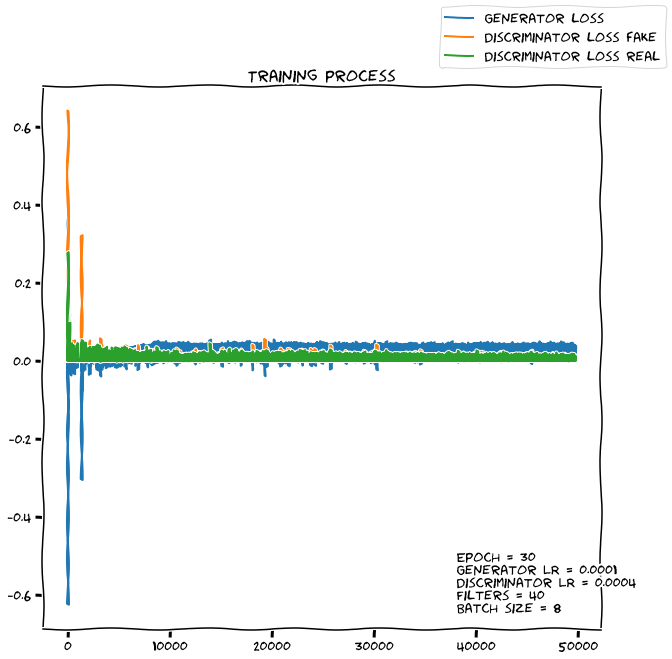

In [16]:
sample_analytics(meta=meta, save=False, show=True)    

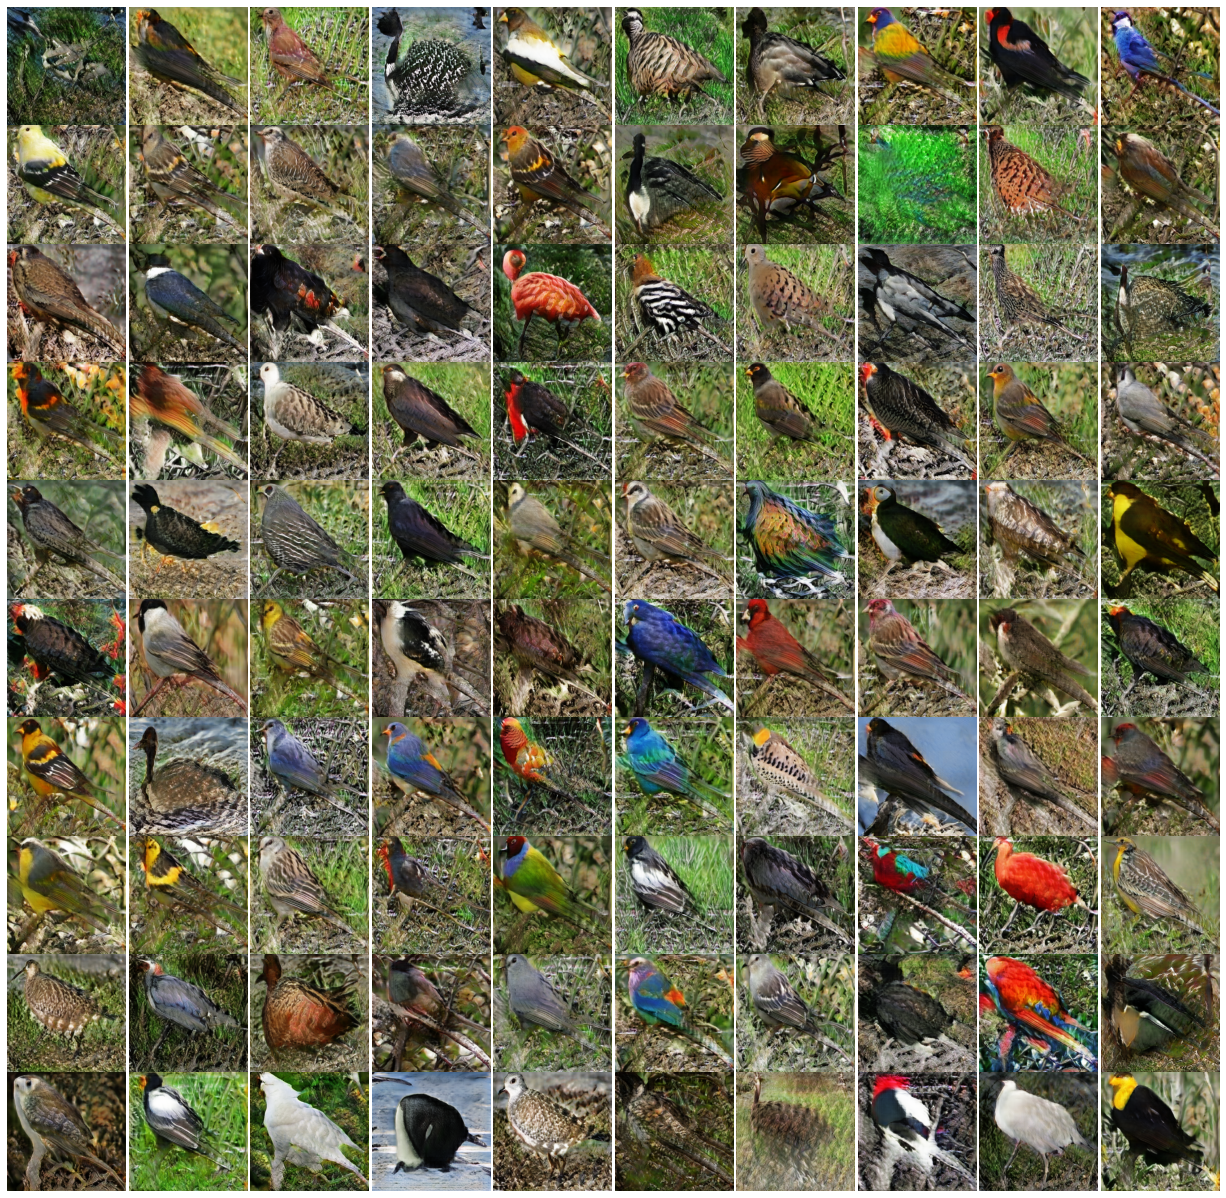

In [22]:
sample_images(epoch = meta['epoch'], save=False, show=True, noise = fixed_noise)

(1, 224, 224, 3)


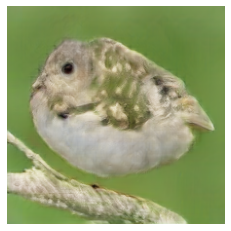

In [18]:
with strategy.scope():
  generator_optimizer.swap_weights()
  generated_image = sample_single_image(
      generator=generator,
      label=11,
      noise=tf.random.truncated_normal((LATENT_DIM,), stddev=1)
  )
  generator_optimizer.swap_weights()

In [19]:
combine_samples(SAMPLES_DIR, 'image_at_epoch_*.jpeg')